In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import helpers
import stx as stx
import utils as ut

In [4]:
# Start by loading the data

pths = dict(sample_2 = dict(cnt = "../data/Allen-2/Allen-2-count-matrix.tsv.gz",
                            img = "../data/Allen-2/tissue_hires_image.png",
                            scf = "../data/Allen-2/scalefactors_json.json",
                            mta = "../data/Allen-2/allen-2-meta.tsv",
                            ),
            sample_1 = dict(cnt = "../data/Allen-1/Allen-1-count-matrix.tsv.gz",
                            img = "../data/Allen-1/tissue_hires_image.png",
                            scf = "../data/Allen-1/scalefactors_json.json",
                            mta = "../data/Allen-1/allen-1-meta.tsv",
                            ),
           )

data_1 = stx.STdata(**pths["sample_1"])
data_2 = stx.STdata(**pths["sample_2"])


In [11]:
bundle = stx.DataBundle([data_1,data_2])

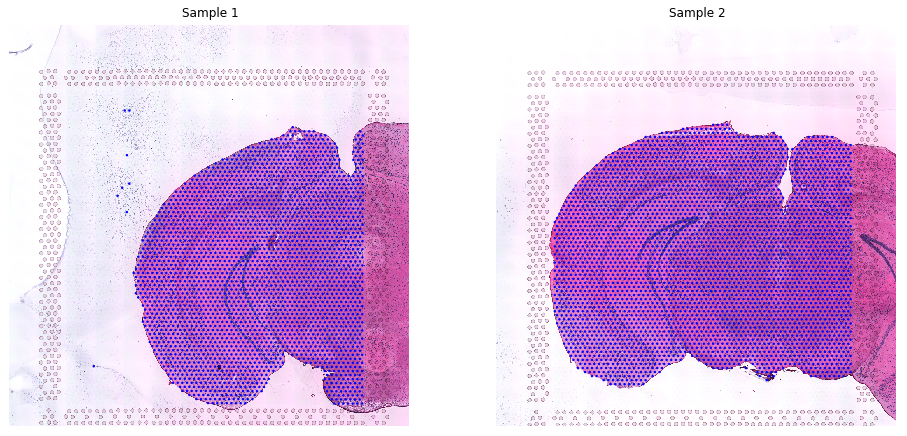

In [5]:
# Our Visium section looks as follows
fig, ax = plt.subplots(1,2,figsize=(16,8))
data_1.plot(ax = ax[0],
            fig = fig,
            marker_size = 2)

data_2.plot(ax = ax[1],
            fig = fig,
            marker_size = 2)

ax[0].set_title("Sample 1")
ax[1].set_title("Sample 2")
plt.show()

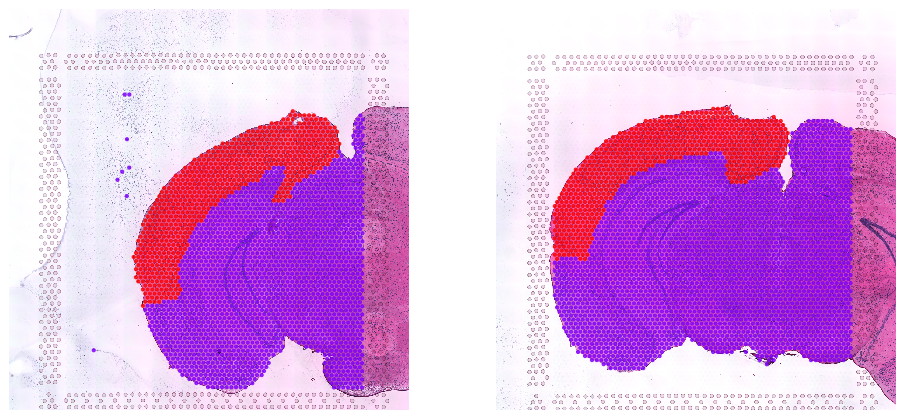

In [6]:
# Our meta data provides a (rather sloppy)
# annotation of isocortex spots

data_1.set_foi('region')
data_2.set_foi('region')

fig,axs = plt.subplots(1,2,figsize = (16,8))
fig,axs = bundle.plot(fig = fig,
            axs = axs,
            cmap = plt.cm.rainbow,
            marker_size = 10,
            alpha = 0.8)
plt.show()

In [28]:
# Looking more specifically at the isocortex
%matplotlib inline

# For an initial quick analysis we could also
# cluster the expression data. 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import umap

np.random.seed(1337)

# specify number of clusters
n_clusters = 9
# specify dimension of subspace spanned by IC's
n_dims = 40

# Setup Dimred. and Clustering
dimred = FastICA(n_components = n_dims)
km = KMeans(n_clusters = n_clusters)

# Select only isocortex spots
sel = bundle.mta['region'].values.flatten() == 1

# normalize the data
ncnt = stx.normalize_cnt(bundle.cnt.values)
# reducre dimensionality
ncnt = dimred.fit_transform(ncnt[sel,:])
# Cluster the data
cidx = km.fit_predict(ncnt)
# Project into 2 dim. space for visualization
umap_crd = umap.UMAP().fit_transform(ncnt)



In [ ]:
# Get indices for selected spots in each
# sample

sub_sel = list()
sub_sel.append(range(0,
               sel[bundle.positions[0]].sum()))

for s in range(1,bundle.n_sets):
    sub_sel.append(range(sub_sel[-1][-1] + 1,
                         sub_sel[-1][-1] + \
                         sel[bundle.positions[s]].sum() +1))


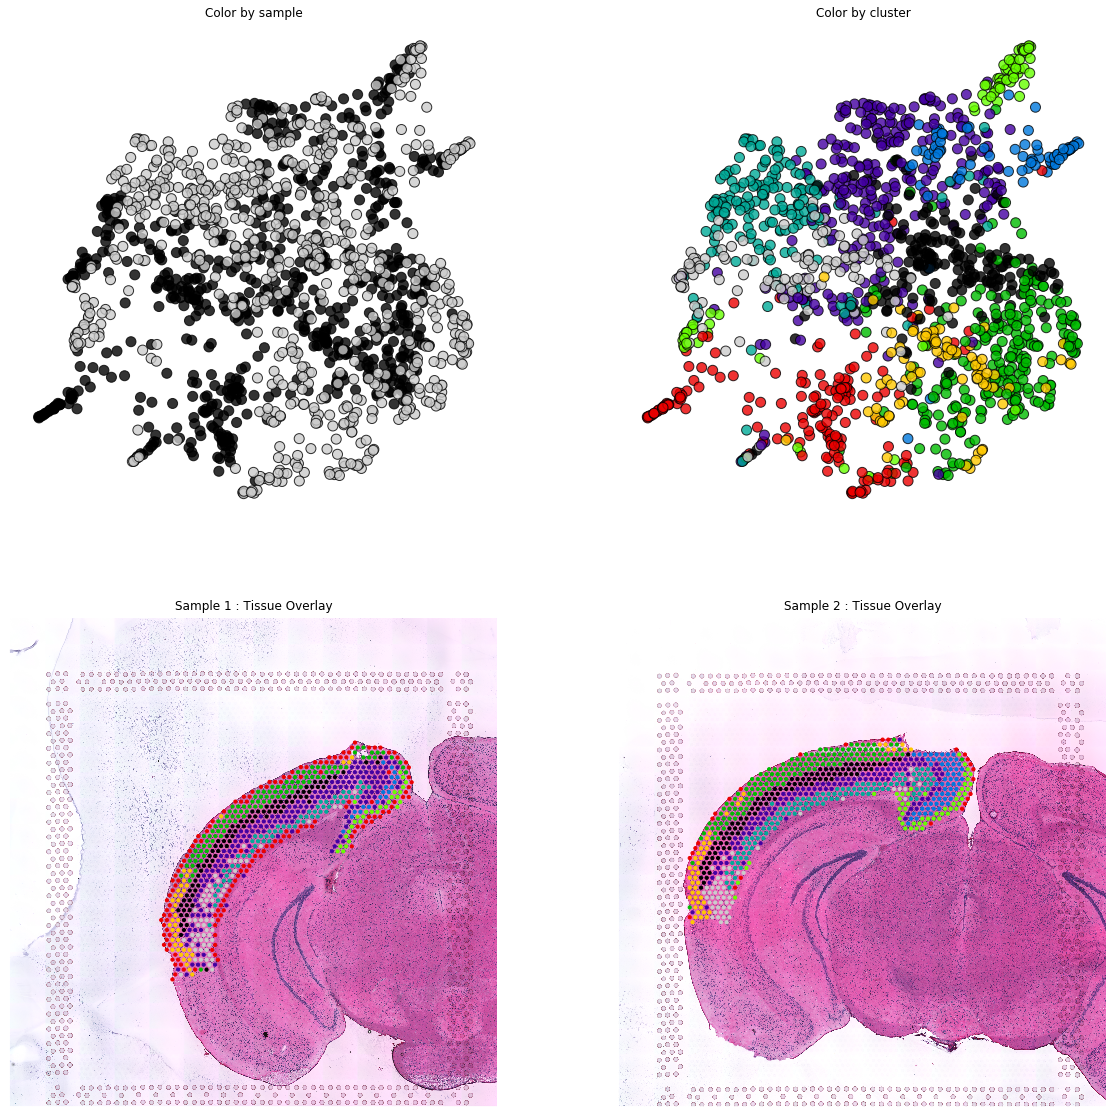

In [29]:
# Visualize results

cmap = plt.cm.nipy_spectral
n_rows = int(1 + np.ceil(bundle.n_sets / 2))

fig, ax = plt.subplots(2,
                       n_rows,
                       figsize = (20,10*n_rows))
ax = ax.flatten()

vals = np.zeros(sel.sum())
vals[sel_1] = 1
vals[sel_2] = 2

# UMAP projection with coloring (QC)
for k,color in enumerate([vals,cidx]):
    sct = ax[k].scatter(umap_crd[:,0],
                        umap_crd[:,1],
                        c = color,
                        cmap = cmap,
                        edgecolor = 'black',
                        alpha = 0.8,
                        s= 100,
                        )

ax[0].set_title("Color by sample")
ax[1].set_title("Color by cluster")

# Tissue overlay (only using selected spots)
for s in range(bundle.n_sets):
    ax[2+s].imshow(bundle.sets[s].img)
    ax[2+s].scatter(bundle.sets[s].crd[sel[bundle.positions[s]],1] \
                    * bundle.sets[s].sf,
                    bundle.sets[s].crd[sel[bundle.positions[s]],0] \
                    * bundle.sets[s].sf,
                    c = cidx[sub_sel[s]],
                    cmap = cmap,
                    s = 10)

    ax[2+s].set_title("Sample " + str(s+1) + " : Tissue Overlay")

for ii in range(4):
    ut.clean_spines(ax[ii])
    ut.clean_ticks(ax[ii])
    ax[ii].set_aspect('equal')